# Nested Sampling Algorithm

- Jeffrey's prior for $D_0$
- Uniform Priors for $\alpha$, $f$ and $\sigma^2_{mn}$


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import scipy.stats as stats
import warnings

In [59]:
def jeff(u,magmin, magmax):
    return magmin*np.exp(u*np.log(magmax/magmin))
def uni(x, magmin, magmax):
    return 1/(magmax, magmin)


## likelihood calc function

In [4]:
@jit
def noisylikelihoodcalc(posn, DT, D, ALPHA, F =0 , varmn = 0):
    # time series
    n = len(posn)

    #init value
    logl = 0
    k_BT =1
    

    # Intial values of the variance mean both noisy and clean
    mob = D * (np.abs(posn[0]) ** ALPHA)
    std_dev_noise = 2 * mob * DT + 2 * varmn
    noisy_mean = posn[0] + (mob * F + k_BT * (ALPHA * D * ((np.abs(posn[0]) ** (ALPHA - 1)) * (np.sign(posn[0]))))) * DT
    
    # log likelihood at 1st step
    logl = logl - ((posn[1] - noisy_mean) ** 2) / (2 * std_dev_noise) - np.log(np.sqrt(2 * np.pi * std_dev_noise))
    
    for i in range(2,n):
        # Mobility at the step
        mob = D * np.abs(posn[i - 1]) ** ALPHA

        # clean variance at the jth step
        std_dev = 2 * mob * DT

        # clean mean position at the jth time step
        mean_dist = posn[i - 1] + (mob * F + ALPHA * D * (np.abs(posn[i - 1]) ** (ALPHA - 1)) * (np.sign(posn[i - 1]))) * DT

        # noisy mean position at the jth step
        noisy_mean = mean_dist - varmn/(std_dev_noise) * (posn[i-1] - noisy_mean)

        # noisy variance at the jth posn
        std_dev_noise = std_dev + varmn * (2 - varmn / std_dev_noise)

        # calculation of log likelihood
        logl = logl - ((posn[i] - noisy_mean) ** 2) / (2 * std_dev_noise) - 0.5 * np.log(2 * np.pi * std_dev_noise)
    
    return logl

## Model for calculating Evidence and with consider Model parameters

Instead of defining different functions for different models we could use the theta_max and theta_min vectors to define the parameters properly.

In [5]:
@jit
def Evidence(data, theta, npoints, tol):
    logZ = 0
    walker = walkergen(npoints, theta_max, theta_min)
    for i in range(0,npoints):
        ll[i] = noisylikelihoodcalc(p_data, 1, walker[i][0], walker[i][1], walker[i][2], walker[i][3])
    
    

In [6]:
@jit
def walkergen(n, tmax, tmin):
    x = np.zeros((n,4))
    for i in range(0,n):
        for j in range(0,4):
            x[i][j] = np.random.uniform(tmin[j],tmax[j])
    return x

In [7]:
# @jit 
def logsum(a, b):
    return max(a,b) + np.log(1+ np.exp(-np.abs(a-b)))

## $\theta_{max}$ and $\theta_{min}$ vectors

we use this to define the priors

In [8]:
D_min = 10**(-4)
D_max = 10**2
# D_min = 0.
# D_max = 1.


f_min = -1.
f_max = 1.

alpha_min = -2.
alpha_max = 2.

varmn_min = 1.
varmn_max = 100.

theta_max_pc = np.array([D_max, alpha_max, f_max, 0])
theta_min_pc = np.array([D_min, alpha_min, f_min, 0])

theta_max_fc = np.array([D_max, alpha_max, 0, 0])
theta_min_fc = np.array([D_min, alpha_min, 0, 0])

theta_max_pmn = np.array([D_max, alpha_max, f_max, varmn_max])
theta_min_pmn = np.array([D_min, alpha_min, f_min, varmn_min])

theta_max_fmn = np.array([D_max, alpha_max, 0, varmn_max])
theta_min_fmn = np.array([D_min, alpha_min, 0, varmn_min])


In [9]:
# p_data = np.array([50,46.743,46.751,40.915,45.066,50.56,44.448,40.518,40.145,39.551,42.887,40.218,44.399,38.416,36.626,35.867,30.252,28.843,26.412,27.815,28.166,32.899,34.738,33.237,24.448,22.771,19.285,24.966,23.912,23.839,23.83,22.253,15.661,20.156,20.166,16.9,15.495,18.734,18.234,17.823,16.052,11.424,9.4223,7.3746,7.2549,7.2847,6.7366,7.7324,6.8572,7.034,5.3564,3.7969,3.4073,4.3653,4.56,4.8884,3.8021,2.9259,3.5701,4.0879,2.3471,0.95298,1.7231,1.7968,1.753,2.1651,2.1354,2.404,2.9188,1.1974,1.3358,1.428,1.8476,2.1991,1.1013,1.3227,0.71634,0.68376,0.89795,1.6167,2.0934,2.4119,1.0693,1.2777,2.2396,0.30283,0.64551,-0.44319,-0.79814,-0.82102,-2.0478,-1.6834,-1.8176,-1.3092,-1.2355,-1.8231,-1.8543,-2.1829,-4.2785,-4.2926])


# my data
# p_data = np.array([50.   , 43.235, 36.248, 30.705, 31.312, 28.791, 26.838, 26.137,       24.245, 23.097, 21.414, 19.042, 20.38 , 20.536, 18.37 , 19.826,       22.181, 24.422, 23.84 , 20.125, 18.406, 21.642, 19.997, 17.496,       17.334, 19.815, 15.026, 15.195, 12.337, 15.354, 19.697, 20.12 ,       16.174, 14.4  , 13.479, 17.593, 15.508, 14.726, 11.388,  9.644,        9.469,  9.747, 11.076,  8.236,  8.134,  8.891,  7.284,  7.751,        6.388,  5.29 ,  4.28 ,  3.221,  2.371,  2.023,  1.591,  2.872,        4.703,  5.233,  4.382,  4.458,  3.87 ,  5.508,  4.44 ,  5.594,        6.053,  7.122,  8.703,  6.282,  6.946,  3.005,  1.706,  2.829,        2.391,  1.722,  0.27 ,  0.477,  0.391,  0.22 ,  0.469,  1.013,        1.807,  2.978,  3.748,  2.164,  3.568,  4.455,  3.843,  4.115,        4.108,  1.415,  2.297,  1.828,  0.968,  0.686,  0.648,  1.19 ,        1.096,  0.899,  1.504,  2.276])

p_data = np.array([50.   , 51.367, 48.699, 44.642, 43.553, 49.184, 49.222, 50.955,       38.148, 46.938, 34.223, 38.415, 36.054, 35.257, 35.473, 29.603,       34.158, 28.346, 33.686, 31.855, 32.454, 36.521, 31.482, 35.63 ,       39.712, 38.944, 37.343, 39.255, 35.665, 31.73 , 28.254, 30.081,       35.46 , 34.247, 32.114, 30.253, 27.704, 27.316, 32.169, 32.617,       27.722, 32.482, 34.431, 28.408, 27.382, 28.881, 29.671, 29.079,       31.088, 33.544, 34.063, 39.901, 38.426, 49.951, 50.612, 54.932,       54.549, 60.98 , 60.88 , 59.873, 64.145, 65.389, 57.596, 49.069,       50.313, 49.782, 44.892, 56.176, 53.266, 52.5  , 43.84 , 38.461,       38.153, 38.319, 34.644, 32.851, 34.693, 31.565, 29.909, 31.77 ,       27.628, 24.255, 20.444, 24.825, 28.336, 30.011, 28.37 , 21.392,       17.319, 18.046, 16.723, 16.915, 19.138, 18.129, 17.593, 14.156,       16.958, 13.758, 17.603, 17.622])

# MCMC walker

Tried my hand at coding a MCMC walker using the Metropolis Hastings algo. The proposal function is a standard gaussian. To make it compatible for different models use can use different step sizes and then set the step sizes for the non fixed parameters to be the same and step size for the fixed parameter to be 0. So the walker is also constrained to walk over a surface that has fixed parameter of the model to be fixed. Setting the proposal function like this means we can define an easier code snippet without having to define multiple methods for different models and then it would be easier to define.

We could also go an easier way and then generate the walkers only in the constrained surface

Have to try both, but have a feeling that the secind method will be more efficient.

In [10]:
# @jit
def MCMCwalker(x, DT, walker, Lstar, N, step = 0):
    
    if step == 0:
        step = 1

    # assigning parameter values for the walker 
    D = walker[0]
    a = walker[1]
    f = walker[2]
    mn = walker[3]
    
    R = 0

    # intializing the walker distribution
    walker_new = np.zeros((N,4))

    # init proposal function
    # proposal for new points in parameter space
    prop = np.zeros(4)

    #rejection count to determine new steps
    rejcount = 0 

    #initial walker value is the intial walker point
    walker_new[0] = walker 

    #counter variable
    i = 1
    
    while i<N:
        
        #setting new values using the proposal function
        for j in range(0,4):
            prop[j] = walker_new[i-1][j] + np.random.normal(0,step)

        # log likelihood of the walker
        llwalker = noisylikelihoodcalc(x, DT, *prop)

        #moving around prior landscape
        if llwalker >= Lstar:
            walker_new[i] = prop
            Lstar = llwalker
        else:
            walker_new[i] = walker_new[i-1]
            rejcount += 1
        i+=1

    # Rejection Ratio
    R = rejcount/N

    #new step
    step = min(step * np.exp( 0.5 - R), 1)
    
    return step, walker_new[-1]         

In [62]:
# @jit
def MCMCwalkerjeff(x, DT, walker, Lstar, N, step = 0):
    
    if step == 0:
        step = 1

    # assigning parameter values for the walker 
    D = walker[0]
    a = walker[1]
    f = walker[2]
    mn = walker[3]
    
    R = 0

    # intializing the walker distribution
    walker_new = np.zeros((N,4))

    # init proposal function
    # proposal for new points in parameter space
    prop = np.zeros(4)

    #rejection count to determine new steps
    rejcount = 0 

    #initial walker value is the intial walker point
    walker_new[0] = walker 

    #counter variable
    i = 1
    
    while i<N:
        
        #setting new values using the proposal function
        for j in range(0,4):
            prop[j] = walker_new[i-1][j] + np.random.normal(0,step)

        # log likelihood of the walker
        llwalker = noisylikelihoodcalc(x, DT, *prop)

        llc = llwalker + jeff(prop,10**(-4),10**2)
        
        #moving around prior landscape
        if llwalker >= Lstar:
            walker_new[i] = prop
            Lstar = llwalker
        else:
            walker_new[i] = walker_new[i-1]
            rejcount += 1
        i+=1

    # Rejection Ratio
    R = rejcount/N

    #new step
    step = min(step * np.exp( 0.5 - R), 1)
    
    return step, walker_new[-1]         

In [11]:
# @jit
def MCMCwalkerfmn(x, DT, walker, Lstar, N, step = 0):
    
    if step == 0:
        step = 1

    # assigning parameter values for the walker 
    D = walker[0]
    a = walker[1]
    f = walker[2]
    mn = walker[3]
    
    R = 0

    # intializing the walker distribution
    walker_new = np.zeros((N,4))

    # init proposal function
    # proposal for new points in parameter space
    prop = np.zeros(4)

    #rejection count to determine new steps
    rejcount = 0 

    #initial walker value is the intial walker point
    walker_new[0] = walker 

    #counter variable
    i = 1
    
    while i<N:
        
        #setting new values using the proposal function
        for j in [0,1,3]:
            prop[j] = walker_new[i-1][j] + np.random.normal(0,step)

        # log likelihood of the walker
        llwalker = noisylikelihoodcalc(x, DT, *prop)

        #moving around prior landscape
        if llwalker >= Lstar:
            walker_new[i] = prop
            Lstar = llwalker
        else:
            walker_new[i] = walker_new[i-1]
            rejcount += 1
        i+=1

    # Rejection Ratio
    R = rejcount/N

    #new step
    step = min(step * np.exp( 0.5 - R), 1)
    
    return step, walker_new[-1]         

In [16]:
# @jit
def MCMCwalkerpc(x, DT, walker, Lstar, N, step = 0):
    
    if step == 0:
        step = 1

    # assigning parameter values for the walker 
    D = walker[0]
    a = walker[1]
    f = walker[2]
    mn = walker[3]
    
    R = 0

    # intializing the walker distribution
    walker_new = np.zeros((N,4))

    # init proposal function
    # proposal for new points in parameter space
    prop = np.zeros(4)

    #rejection count to determine new steps
    rejcount = 0 

    #initial walker value is the intial walker point
    walker_new[0] = walker 

    #counter variable
    i = 1
    
    while i<N:
        
        #setting new values using the proposal function
        for j in range(0,3):
            prop[j] = walker_new[i-1][j] + np.random.normal(0,step)

        # log likelihood of the walker
        llwalker = noisylikelihoodcalc(x, DT, *prop)

        #moving around prior landscape
        if llwalker >= Lstar :
            walker_new[i] = prop
            Lstar = llwalker
        else:
            walker_new[i] = walker_new[i-1]
            rejcount += 1
        i+=1

    # Rejection Ratio
    R = rejcount/N

    #new step
    step = min(step * np.exp( 0.5 - R), 1)
    
    return step, walker_new[-1]         

In [13]:
# @jit
def MCMCwalkerfc(x, DT, walker, Lstar, N, step = 0):
    
    if step == 0:
        step = 1

    # assigning parameter values for the walker 
    D = walker[0]
    a = walker[1]
    f = walker[2]
    mn = walker[3]
    
    R = 0

    # intializing the walker distribution
    walker_new = np.zeros((N,4))

    # init proposal function
    # proposal for new points in parameter space
    prop = np.zeros(4)

    #rejection count to determine new steps
    rejcount = 0 

    #initial walker value is the intial walker point
    walker_new[0] = walker 

    #counter variable
    i = 1
    
    while i<N:
        
        #setting new values using the proposal function
        for j in [0,1]:
            prop[j] = walker_new[i-1][j] + np.random.normal(0,step)

        # log likelihood of the walker
        llwalker = noisylikelihoodcalc(x, DT, *prop)

        #moving around prior landscape
        if llwalker >= Lstar:
            walker_new[i] = prop
            Lstar = llwalker
        else:
            walker_new[i] = walker_new[i-1]
            rejcount += 1
        i+=1

    # Rejection Ratio
    R = rejcount/N

    #new step
    step = min(step * np.exp( 0.5 - R), 1)
    
    return step, walker_new[-1]         

# Nested Sampling Code starts here

In [63]:
# steps for the random walkers in the MCMC algo
Nsteps = 18000

# no of walkers considered
npoints = 100

# init likelihood of pull, clean and free, clean models
llpc = np.zeros(npoints)
llfc = np.zeros(npoints)
llpmn = np.zeros(npoints)
llfmn = np.zeros(npoints)

# walkers pull clean and walker free clean
walkers_pc = np.array(walkergen(npoints, theta_max_pc,theta_min_pc))
walkers_fc = np.array(walkergen(npoints, theta_max_fc,theta_min_fc))
walkers_pmn = np.array(walkergen(npoints, theta_max_pmn,theta_min_pmn))
walkers_fmn = np.array(walkergen(npoints, theta_max_fmn,theta_min_fmn))

# likelihood  of Mpc and Mfc
for i in range(0,npoints):
    llpc[i] = noisylikelihoodcalc(p_data, 1, *walkers_pc[i])
    llfc[i] = noisylikelihoodcalc(p_data, 1, *walkers_fc[i])
    llpmn[i] = noisylikelihoodcalc(p_data, 1, *walkers_pmn[i])
    llfmn[i] = noisylikelihoodcalc(p_data, 1, *walkers_fmn[i])


# wt = 1/(npoints + 1)
logwt = -np.log(npoints + 1)

#Zpc is Z pull clean
#Zfc is Z free clean

# these are the remainders in the jth iteration
logZpcrem = np.log(0)
logZfcrem = np.log(0)
logZpmnrem = np.log(0)
logZfmnrem = np.log(0)

# these are the Log Evidences for the respective models
logZpc = np.log(0)
logZfc = np.log(0)
logZpmn = np.log(0)
logZfmn = np.log(0)


logp_pc = min(llpc) + logwt
logp_fc = min(llfc) + logwt
logp_pmn = min(llpmn) + logwt
logp_fmn = min(llfmn) + logwt


logZpmn = logsum(logZpmn,logp_pmn)
logZfmn = logsum(logZfmn,logp_fmn)
logZpc = logsum(logZpc,logp_pc)
logZfc = logsum(logZfc,logp_fc)


for i in range(0, npoints):
    logZfcrem = logsum(llfc[i], logZfcrem)
    logZpcrem = logsum(llpc[i], logZpcrem)
    logZfmnrem = logsum(llfmn[i], logZfmnrem)
    logZpmnrem = logsum(llpmn[i], logZpmnrem)

logZfcrem = logZfcrem + logwt
logZpcrem = logZpcrem + logwt
logZfmnrem = logZfmnrem + logwt
logZpmnrem = logZpmnrem + logwt


logZpc,min(llpc),logZfc,min(llfc),logZpmn,min(llpmn),logZfmn,min(llfmn)

/tmp/ipykernel_123190/3447937050.py:34: RuntimeWarning: divide by zero encountered in log
  logZpcrem = np.log(0)
/tmp/ipykernel_123190/3447937050.py:35: RuntimeWarning: divide by zero encountered in log
  logZfcrem = np.log(0)
/tmp/ipykernel_123190/3447937050.py:36: RuntimeWarning: divide by zero encountered in log
  logZpmnrem = np.log(0)
/tmp/ipykernel_123190/3447937050.py:37: RuntimeWarning: divide by zero encountered in log
  logZfmnrem = np.log(0)
/tmp/ipykernel_123190/3447937050.py:40: RuntimeWarning: divide by zero encountered in log
  logZpc = np.log(0)
/tmp/ipykernel_123190/3447937050.py:41: RuntimeWarning: divide by zero encountered in log
  logZfc = np.log(0)
/tmp/ipykernel_123190/3447937050.py:42: RuntimeWarning: divide by zero encountered in log
  logZpmn = np.log(0)
/tmp/ipykernel_123190/3447937050.py:43: RuntimeWarning: divide by zero encountered in log
  logZfmn = np.log(0)


(-636281.0864339684,
 -636276.4713134515,
 -78023.51459126946,
 -78018.89947075261,
 -1621767.7177962924,
 -1621763.1026757755,
 -5492.599568514367,
 -5487.984447997525)

In [64]:
# initial stepsize
step = 0

# int index of the loop
j=1

# tolerance value for stopping condition
tol = np.log(10**(-4))

# lowest likelihood in each iteration
lstarpc = []

# log weight
logwt = -np.log(npoints + 1)

# posterior avergae and posterior samples
lpostavgpc = np.zeros(4)
lpostpc = np.zeros(4)

# posterior 2nd moment and posterior 2nd moment samples
post2mavgpc = np.zeros(4)
post2mpc = np.zeros(4)

#information to calculate error
Hpc = 0

#stopping ratio calculator
Rpc = logZpcrem - logZpc

if Rpc < tol:
    print("term1 stop")
    print(logZpc)

while True:
    # log width contraction
    logwt = logwt + np.log(npoints/(npoints+1))

    # log likelihood calculation
    loglpc = [noisylikelihoodcalc(p_data, 1, *walkers_pc[i]) for i in range(0,npoints)]

    # lowest likelihood of all the walkers
    lstarpc.append(min(loglpc))

    # walker index with minimum loglikelihood
    ppc = np.argmin(loglpc)

    # previous iterations log Evidence
    prevlogZpc = logZpc

    # previous iteration's H(information)
    prevHpc = Hpc
    
    # log Z finding
    logZpc = logsum(logZpc, (lstarpc[-1] + logwt))

    # posterior sample
    lpostpc = (walkers_pc[ppc])*np.exp(lstarpc[-1])*np.exp(logwt)

    #information calculation
    Hpc += np.exp(logwt)*np.exp(lstarpc[-1])*lstarpc[-1]

    print("Information")
    print(Hpc)

    # posterior 2nd moment sample
    post2mpc = ((walkers_pc[ppc]) ** 2) * np.exp(lstarpc[-1]) * np.exp(logwt)

    # posterior summation after each iteration
    lpostavgpc = lpostavgpc + lpostpc

    # posterior 2nd moment average
    post2mavgpc = post2mavgpc + post2mpc
    
    print("posterior");
    print(lpostavgpc);
    
    print("Evidence");
    print(logZpc);

    # init Zremaining for the jth iteration
    logZpcrem = np.log(0)

    # calculate Zremaining for the jth iteration
    for i in range(0, npoints):
        logZpcrem = logsum(loglpc[i], logZpcrem)
        
    logZpcrem = logZpcrem + logwt

    print( "Zrem =  "+str(logZpcrem));
    print("lowest likelihood = "+str(min(loglpc)))

    # ratio that determines the stopping ratio
    Rpc = logZpcrem - logZpc
    
    print("ratio")
    print(Rpc)

    #break if stopping ratio is less than tolerance
    if Rpc < tol:
        break
        
    # randomly select a walker to copy and random walk
    newwalkernumber = np.random.randint(0,npoints)

    # parameters of the randomly selected walker
    thetawalker = walkers_pc[newwalkernumber]

    # walker replacement  
    trace = MCMCwalkerpc(p_data, 1, thetawalker, lstarpc[-1] , Nsteps, step)

    # step modulation in MCMC walker
    # step = trace[0]
    step = 1

    # replacing the worst walker with the copied walker that undergoes a random walk
    walkers_pc[ppc] = trace[1]

# final evidence calulcation
LogfinalZpc = logsum(prevlogZpc, logZpcrem)

LogfinalZpc

Information
0.0
posterior
[0. 0. 0. 0.]
Evidence
-636280.3982495771
Zrem =  -306.6225877847995
lowest likelihood = -636276.4713134515
ratio
635973.7756617924
Information
0.0
posterior
[0. 0. 0. 0.]
Evidence
-341864.80501003464
Zrem =  -293.38841479919506
lowest likelihood = -341860.16998885607
ratio
341571.41659523547
Information
0.0
posterior
[0. 0. 0. 0.]
Evidence
-328804.4247661678
Zrem =  -289.39019651899366
lowest likelihood = -328799.7797946584
ratio
328515.03456964885
Information
0.0
posterior
[0. 0. 0. 0.]
Evidence
-268240.4407221766
Zrem =  -289.38364066470433
lowest likelihood = -268235.78580033634
ratio
267951.0570815119


/tmp/ipykernel_123190/3929159730.py:81: RuntimeWarning: divide by zero encountered in log
  logZpcrem = np.log(0)


Information
0.0
posterior
[0. 0. 0. 0.]
Evidence
-253678.06145730265
Zrem =  -289.3823777426466
lowest likelihood = -253673.39658513156
ratio
253388.67907956
Information
0.0
posterior
[0. 0. 0. 0.]
Evidence
-221888.06788448093
Zrem =  -288.6699849441054
lowest likelihood = -221883.39306197898
ratio
221599.39789953682
Information
0.0
posterior
[0. 0. 0. 0.]
Evidence
-198382.08849977047
Zrem =  -282.82856178073854
lowest likelihood = -198377.40372693766
ratio
198099.25993798973
Information
0.0
posterior
[0. 0. 0. 0.]
Evidence
-87697.61611756882
Zrem =  -282.83848463526783
lowest likelihood = -87692.92139440514
ratio
87414.77763293355
Information
0.0
posterior
[0. 0. 0. 0.]
Evidence
-68147.4143006915
Zrem =  -282.8484214227754
lowest likelihood = -68142.70962719698
ratio
67864.56587926872
Information
0.0
posterior
[0. 0. 0. 0.]
Evidence
-61663.211953196005
Zrem =  -282.8583559271714
lowest likelihood = -61658.497329370635
ratio
61380.35359726883
Information
0.0
posterior
[0. 0. 0. 0.]
Evi

-280.85979681615703

In [65]:
# init posterior avg at the jmax iteration
lapc = np.zeros(4)
l2pc = np.zeros(4)
lh = 0
Hpcfin = 0

# calculation of posterior avg at the jmax iteration
for i in range(0,npoints):
    lapc += walkers_pc[i] * np.exp(llpc[i])
    l2pc += (walkers_pc[i]**2) * np.exp(llpc[i])
    lh += llpc[i]*np.exp(llpc[i])
    
lapc *= np.exp(logwt)
l2pc *= np.exp(logwt)
lh *= np.exp(logwt)

# final posterior average
postfinpc = lpostavgpc+lapc

# final posterior 2 moment
post2mfinpc = post2mavgpc+l2pc

# dividing by the evidence of the model to find the posterior
normpostfinpc = postfinpc/np.exp(LogfinalZpc)

# normalizing posterior 2nd moment
normpost2mfinpc = post2mfinpc/np.exp(LogfinalZpc)

# calculating final information
Hpcfin = prevHpc + lh
Hpcfin = Hpcfin/np.exp(LogfinalZpc) - LogfinalZpc
logZerrpc = np.sqrt(Hpcfin/npoints)

# variance and error in the parameters
varpc = normpost2mfinpc - normpostfinpc**2
stddevpc = np.sqrt(varpc)

# printing information
print("Posterior theta = "+ str(normpostfinpc)+" Error = "+str(stddevpc))
print("ln(Evidence) = "+str(LogfinalZpc)+" +/- "+str(logZerrpc))

Posterior theta = [ 0.16153386  1.21687923 -0.06937017  0.        ] Error = [0.8958427  0.19281739 0.0233372  0.        ]
ln(Evidence) = -280.85979681615703 +/- 0.16265216180178851


## Posterior Value using $Model_{pull, clean}$

The Log Evidence is given as:

$$\ln(Z) = 183.9 \pm 0.21$$

The Posterior averages are given as:
- $D_0 = 0.169 \pm 0.004$
- $\alpha = 0.99 \pm 0.024 $
- $f = -0.29 \pm 0.03$

In [66]:
#initial step size
step = 1

# init index
j=1

#tolerance for stopping condition
tol = np.log(10**(-4))

# lowest likelihood for the jth iteration
lstarfc = []

# log wth value for prior mass
logwt = -np.log(npoints + 1)

# posterior average and posterior samples
lpostavgfc = np.zeros(4)
lpostfc = np.zeros(4)

#information
Hfc = 0

# posterior 2nd moment and posterior 2nd moment samples
post2mavgfc = np.zeros(4)
post2mfc = np.zeros(4)

# stopping ratio
Rfc = logZfcrem - logZfc

# stopping condition
if Rfc< tol:
    print(logZfc)

while True:
    # log width contraction
    logwt = logwt + np.log(npoints/(npoints+1))

    # log likelihood calculation
    loglfc = [noisylikelihoodcalc(p_data, 1, *walkers_fc[i]) for i in range(0,npoints)]

    # lowest likelihood of all the walkers
    lstarfc.append(min(loglfc))

    pfc = np.argmin(loglfc)

    # storing the evidence of the previous iteration
    prevlogZfc = logZfc

    #storing the information of the previous iteration
    prevHfc = Hfc
    
    # log Z finding
    logZfc = logsum(logZfc, (lstarfc[-1] + logwt))

    # posterior samples
    lpostfc = (walkers_fc[pfc])*np.exp(lstarfc[-1])*np.exp(logwt)

    #information
    Hfc += np.exp(logwt)*np.exp(lstarfc[-1])*lstarfc[-1]

    #posterior 2m samples
    post2mfc = ((walkers_fc[pfc])**2)*np.exp(lstarfc[-1])*np.exp(logwt)
    
    # posterior average
    lpostavgfc = lpostavgfc + lpostfc

    #posterior 2m average
    post2mavgfc = post2mavgfc + post2mfc

    print("posterior");
    print(lpostavgfc);
    
    print("Evidence");
    print(logZfc);

    # init Z remaining of the jth iteration
    logZfcrem = np.log(0)

    # calculating Z remaning of the jth iteration
    for i in range(0, npoints):
        logZfcrem = logsum(loglfc[i], logZfcrem)
        
    logZfcrem = logZfcrem + logwt

    print( "Zrem =  "+str(logZfcrem));
    print("lowest likelihood = "+str(min(loglfc)))

    # ratio that determines the stopping ratio
    Rfc = logZfcrem - logZfc
    
    print("ratio")
    print(Rfc)

    #stopping condition and breaks loop
    if Rfc < tol:
        break
        
    # randomly select a walker to copy and random walk
    newwalkernumber = np.random.randint(0,npoints)

    # parameters of the randomly selected walker
    # thetawalker = np.array(walkers_fc[newwalkernumber])

    # walker replacement  
    trace = MCMCwalkerfc(p_data, 1, thetawalker, lstarfc[-1] , Nsteps, 1)

    # step modulation for the random walk
    step = 1

    # replacement of the worst walker with walker performing random walk
    walkers_fc[pfc] = trace[1]
    walkers_fc[pfc][2] = 0
    walkers_fc[pfc][3] = 0

#final Z calculation
LogfinalZfc = logsum(prevlogZfc, logZfcrem)

LogfinalZfc

posterior
[0. 0. 0. 0.]
Evidence
-78022.82640687823
Zrem =  -291.59263465021434
lowest likelihood = -78018.89947075261
ratio
77731.23377222802
posterior
[0. 0. 0. 0.]
Evidence
-38458.22601126065
Zrem =  -283.6135887508824
lowest likelihood = -38453.590990082106
ratio
38174.612422509774


/tmp/ipykernel_123190/1927483834.py:77: RuntimeWarning: divide by zero encountered in log
  logZfcrem = np.log(0)


posterior
[0. 0. 0. 0.]
Evidence
-27208.572469263112
Zrem =  -282.91019663238455
lowest likelihood = -27203.92749775371
ratio
26925.66227263073
posterior
[0. 0. 0. 0.]
Evidence
-19391.942261929
Zrem =  -282.510729322738
lowest likelihood = -19387.287340088747
ratio
19109.431532606264
posterior
[0. 0. 0. 0.]
Evidence
-18095.109845842868
Zrem =  -282.22967072693956
lowest likelihood = -18090.44497367176
ratio
17812.88017511593
posterior
[0. 0. 0. 0.]
Evidence
-16008.668362744675
Zrem =  -282.0138919906764
lowest likelihood = -16003.993540242715
ratio
15726.654470753998
posterior
[0. 0. 0. 0.]
Evidence
-15235.079897605074
Zrem =  -281.83980031986346
lowest likelihood = -15230.39512477226
ratio
14953.24009728521
posterior
[0. 0. 0. 0.]
Evidence
-14491.844310831315
Zrem =  -281.70208926075117
lowest likelihood = -14487.149587667649
ratio
14210.142221570564
posterior
[0. 0. 0. 0.]
Evidence
-5485.429157908379
Zrem =  -281.57681318747655
lowest likelihood = -5480.7244844138595
ratio
5203.85234

-279.97000336519784

In [67]:
# init posterior avg at the jmax iteration
lafc = np.zeros(4)
l2fc = np.zeros(4)
lahfc = 0

Hfcfin = 0

# calculation of posterior avg at the jmax iteration
for i in range(0,npoints):
    lafc += walkers_fc[i] * np.exp(llfc[i])
    l2fc += (walkers_fc[i]**2) * np.exp(llfc[i])
    lahfc += llfc[i]*np.exp(llfc[i])
    
lafc *= np.exp(logwt)
l2fc *= np.exp(logwt)
lahfc *= np.exp(logwt)

#final posterior calculation
postfinfc = lpostavgfc+lafc
post2mfinfc = post2mavgfc+l2fc

# dividing the posterior by the evidence
normpostfinfc = postfinfc/np.exp(LogfinalZfc)
normpost2mfinfc = post2mfinfc/np.exp(LogfinalZfc)

# information final calculation
Hfcfin = prevHfc + lahfc
Hfcfin = Hfcfin/np.exp(LogfinalZfc) - LogfinalZfc
logZerrfc = np.sqrt(Hfcfin/npoints)

# variance and eror of posterior parameters
varfc = normpost2mfinfc - normpostfinfc**2
stddevfc = np.sqrt(varfc)

# printing information
print("Posterior theta = "+ str(normpostfinfc)+" Error = "+str(stddevfc))
print("ln(Evidence) = "+str(LogfinalZfc)+" +/- "+str(logZerrfc))

Posterior theta = [0.08555065 1.29898997 0.         0.        ] Error = [0.06215268 0.07803177 0.         0.        ]
ln(Evidence) = -279.97000336519784 +/- 0.10162840037861613


# Nested sampling code for noisy models

## commented code

In [111]:
# # steps for the random walkers in the MCMC algo
# Nsteps = 10000

# # no of walkers considered
# npoints = 100

# # init likelihood of pull, clean and free, clean models
# llpmn = np.zeros(npoints)
# llfmn = np.zeros(npoints)

# # walkers pull clean and walker free clean
# walkers_pmn = np.array(walkergen(npoints, theta_max_pmn,theta_min_pmn))
# walkers_fmn = np.array(walkergen(npoints, theta_max_fmn,theta_min_fmn))

# # print(walkers_fmn)
# # print(walkers_pmn)

# # likelihood  of Mpmn and Mfmn
# for i in range(0,npoints):
#     llpmn[i] = noisylikelihoodcalc(p_data, 1, *walkers_pmn[i])
#     llfmn[i] = noisylikelihoodcalc(p_data, 1, *walkers_fmn[i])


# # wt = 1/(npoints + 1)
# logwt = -np.log(npoints + 1)

# #Zpmn is Z pull clean
# #Zfmn is Z free clean

# # these are the remainders in the jth iteration
# logZpmnrem = np.log(0)
# logZfmnrem = np.log(0)

# # these are the Log Evidences for the respective models
# logZpmn = np.log(0)
# logZfmn = np.log(0)


# logp_pmn = min(llpmn) + logwt
# logp_fmn = min(llfmn) + logwt

# logZpmn = logsum(logZpmn,logp_pmn)
# logZfmn = logsum(logZfmn,logp_fmn)


# for i in range(0, npoints):
#     logZfmnrem = logsum(llfmn[i], logZfmnrem)
#     logZpmnrem = logsum(llpmn[i], logZpmnrem)

# logZfmnrem = logZfmnrem + logwt
# logZpmnrem = logZpmnrem + logwt

# logZpmn,min(llpmn),logZfmn,min(llfmn)

/tmp/ipykernel_63131/1179302201.py:31: RuntimeWarning: divide by zero encountered in log
  logZpmnrem = np.log(0)
/tmp/ipykernel_63131/1179302201.py:32: RuntimeWarning: divide by zero encountered in log
  logZfmnrem = np.log(0)
/tmp/ipykernel_63131/1179302201.py:35: RuntimeWarning: divide by zero encountered in log
  logZpmn = np.log(0)
/tmp/ipykernel_63131/1179302201.py:36: RuntimeWarning: divide by zero encountered in log
  logZfmn = np.log(0)


(-316139.2501793184,
 -316134.63505880156,
 -12067.878821259246,
 -12063.263700742405)

## commented code end

In [68]:
# initial stepsize
step = 1

# int index of the loop
j=1

# tolerance value for stopping condition
tol = np.log(10**(-4))

# lowest likelihood in each iteration
lstarpmn = []

# log weight
logwt = -np.log(npoints + 1)

# posterior avergae and posterior samples
lpostavgpmn = np.zeros(4)
lpostpmn = np.zeros(4)

# posterior 2nd moment and posterior 2nd moment samples
post2mavgpmn = np.zeros(4)
post2mpmn = np.zeros(4)

#information to calculate error
Hpmn = 0

#stopping ratio calculator
Rpmn = logZpmnrem - logZpmn

if Rpmn < tol:
    print("term1 stop")
    print(logZpmn)

while True:
    # log width contraction
    logwt = logwt + np.log(npoints/(npoints+1))

    # log likelihood calculation
    loglpmn = [noisylikelihoodcalc(p_data, 1, *walkers_pmn[i]) for i in range(0,npoints)]

    # lowest likelihood of all the walkers
    lstarpmn.append(min(loglpmn))

    # walker index with minimum loglikelihood
    ppmn = np.argmin(loglpmn)

    # previous iterations log Evidence
    prevlogZpmn = logZpmn

    # previous iteration's H(information)
    prevHpmn = Hpmn
    
    # log Z finding
    logZpmn = logsum(logZpmn, (lstarpmn[-1] + logwt))

    # posterior sample
    lpostpmn = (walkers_pmn[ppmn])*np.exp(lstarpmn[-1])*np.exp(logwt)

    #information calculation
    Hpmn += np.exp(logwt)*np.exp(lstarpmn[-1])*lstarpmn[-1]

    print("Information")
    print(Hpmn)

    # posterior 2nd moment sample
    post2mpmn = ((walkers_pmn[ppmn]) ** 2) * np.exp(lstarpmn[-1]) * np.exp(logwt)

    # posterior summation after each iteration
    lpostavgpmn = lpostavgpmn + lpostpmn

    # posterior 2nd moment average
    post2mavgpmn = post2mavgpmn + post2mpmn
    
    print("posterior");
    print(lpostavgpmn);
    
    print("Evidence");
    print(logZpmn);

    # init Zremaining for the jth iteration
    logZpmnrem = np.log(0)

    # calculate Zremaining for the jth iteration
    for i in range(0, npoints):
        logZpmnrem = logsum(loglpmn[i], logZpmnrem)
        
    logZpmnrem = logZpmnrem + logwt

    print( "Zrem =  "+str(logZpmnrem));
    print("lowest likelihood = "+str(min(loglpmn)))

    # ratio that determines the stopping ratio
    Rpmn = logZpmnrem - logZpmn
    
    print("ratio")
    print(Rpmn)

    #break if stopping ratio is less than tolerance
    if Rpmn < tol:
        break
        
    # randomly select a walker to copy and random walk
    newwalkernumber = np.random.randint(0,npoints)

    # parameters of the randomly selected walker
    thetawalker = walkers_pmn[newwalkernumber]

    # walker replacement  
    trace = MCMCwalker(p_data, 1, thetawalker, lstarpmn[-1] , Nsteps, step)

    # step modulation in MCMC walker
    step = 1

    # replacing the worst walker with the copied walker that undergoes a random walk
    walkers_pmn[ppmn] = trace[1]

# final evidence calulcation
LogfinalZpmn = logsum(prevlogZpmn, logZpmnrem)

LogfinalZpmn

Information
0.0
posterior
[0. 0. 0. 0.]
Evidence
-1621767.0296119011
Zrem =  -315.7971499341474
lowest likelihood = -1621763.1026757755
ratio
1621451.232461967
Information
0.0
posterior
[0. 0. 0. 0.]
Evidence
-904209.0000895201
Zrem =  -288.89717466760726
lowest likelihood = -904204.3650683416
ratio
903920.1029148526


/tmp/ipykernel_123190/178806207.py:81: RuntimeWarning: divide by zero encountered in log
  logZpmnrem = np.log(0)


Information
0.0
posterior
[0. 0. 0. 0.]
Evidence
-894950.364220939
Zrem =  -288.7666446369537
lowest likelihood = -894945.7192494296
ratio
894661.597576302
Information
0.0
posterior
[0. 0. 0. 0.]
Evidence
-794432.424471768
Zrem =  -288.3772755953786
lowest likelihood = -794427.7695499277
ratio
794144.0471961726
Information
0.0
posterior
[0. 0. 0. 0.]
Evidence
-519538.9243327377
Zrem =  -288.3858247976222
lowest likelihood = -519534.25946056657
ratio
519250.5385079401
Information
0.0
posterior
[0. 0. 0. 0.]
Evidence
-456190.1419623824
Zrem =  -288.39577512847535
lowest likelihood = -456185.46713988046
ratio
455901.746187254
Information
0.0
posterior
[0. 0. 0. 0.]
Evidence
-404708.33741704584
Zrem =  -288.4057254593283
lowest likelihood = -404703.65264421306
ratio
404419.9316915865
Information
0.0
posterior
[0. 0. 0. 0.]
Evidence
-385777.77992250887
Zrem =  -288.41567579015975
lowest likelihood = -385773.0851993452
ratio
385489.3642467187
Information
0.0
posterior
[0. 0. 0. 0.]
Evidence


-280.9478245663572

In [69]:
# init posterior avg at the jmax iteration
lapmn = np.zeros(4)
l2pmn = np.zeros(4)
lhmn = 0
Hpmnfin = 0

# calculation of posterior avg at the jmax iteration
for i in range(0,npoints):
    lapmn += walkers_pmn[i] * np.exp(llpmn[i])
    l2pmn += (walkers_pmn[i]**2) * np.exp(llpmn[i])
    lh += llpmn[i]*np.exp(llpmn[i])
    
lapmn *= np.exp(logwt)
l2pmn *= np.exp(logwt)
lhmn *= np.exp(logwt)

# final posterior average
postfinpmn = lpostavgpmn+lapmn

# final posterior 2 moment
post2mfinpmn = post2mavgpmn+l2pmn

# dividing by the evidence of the model to find the posterior
normpostfinpmn = postfinpmn/np.exp(LogfinalZpmn)

# normalizing posterior 2nd moment
normpost2mfinpmn = post2mfinpmn/np.exp(LogfinalZpmn)

# calculating final information
Hpmnfin = prevHpmn + lhmn
Hpmnfin = Hpmnfin/np.exp(LogfinalZpmn) - LogfinalZpmn
logZerrpmn = np.sqrt(Hpmnfin/npoints)

# variance and error in the parameters
varpmn = normpost2mfinpmn - normpostfinpmn**2
stddevpmn = np.sqrt(varpmn)

# printing information
print("Posterior theta = "+ str(normpostfinpmn)+" Error = "+str(stddevpmn))
print("ln(Evidence) = "+str(LogfinalZpmn)+" +/- "+str(logZerrpmn))

Posterior theta = [ 0.20698807  1.45738209 -0.09704603  2.54524923] Error = [2.6247608  0.31987455 0.03550622 0.85836432]
ln(Evidence) = -280.9478245663572 +/- 0.20659392005745184


## Posterior Value using $Model_{pull, clean}$

The Log Evidence is given as:

$$\ln(Z) = 183.9 \pm 0.21$$

The Posterior averages are given as:
- $D_0 = 0.169 \pm 0.004$
- $\alpha = 0.99 \pm 0.024 $
- $f = -0.29 \pm 0.03$

In [70]:
#initial step size
step = 1

# init index
j=1

#tolerance for stopping condition
tol = np.log(10**(-4))

# lowest likelihood for the jth iteration
lstarfmn = []

# log wth value for prior mass
logwt = -np.log(npoints + 1)

# posterior average and posterior samples
lpostavgfmn = np.zeros(4)
lpostfmn = np.zeros(4)

#information
Hfmn = 0

# posterior 2nd moment and posterior 2nd moment samples
post2mavgfmn = np.zeros(4)
post2mfmn = np.zeros(4)

# stopping ratio
Rfmn = logZfmnrem - logZfmn

# stopping condition
if Rfmn< tol:
    print(logZfmn)

while True:
    # log width contraction
    logwt = logwt + np.log(npoints/(npoints+1))

    # log likelihood calculation
    loglfmn = [noisylikelihoodcalc(p_data, 1, *walkers_fmn[i]) for i in range(0,npoints)]

    # lowest likelihood of all the walkers
    lstarfmn.append(min(loglfmn))

    pfmn = np.argmin(loglfmn)

    # storing the evidence of the previous iteration
    prevlogZfmn = logZfmn

    #storing the information of the previous iteration
    prevHfmn = Hfmn
    
    # log Z finding
    logZfmn = logsum(logZfmn, (lstarfmn[-1] + logwt))

    # posterior samples
    lpostfmn = (walkers_fmn[pfmn])*np.exp(lstarfmn[-1])*np.exp(logwt)

    #information
    Hfmn += np.exp(logwt)*np.exp(lstarfmn[-1])*lstarfmn[-1]

    #posterior 2m samples
    post2mfmn = ((walkers_fmn[pfmn])**2)*np.exp(lstarfmn[-1])*np.exp(logwt)
    
    # posterior average
    lpostavgfmn = lpostavgfmn + lpostfmn

    #posterior 2m average
    post2mavgfmn = post2mavgfmn + post2mfmn

    print("posterior");
    print(lpostavgfmn);
    
    print("Evidence");
    print(logZfmn);

    # init Z remaining of the jth iteration
    logZfmnrem = np.log(0)

    # calculating Z remaning of the jth iteration
    for i in range(0, npoints):
        logZfmnrem = logsum(loglfmn[i], logZfmnrem)
        
    logZfmnrem = logZfmnrem + logwt

    print( "Zrem =  "+str(logZfmnrem));
    print("lowest likelihood = "+str(min(loglfmn)))

    # ratio that determines the stopping ratio
    Rfmn = logZfmnrem - logZfmn
    
    print("ratio")
    print(Rfmn)

    #stopping condition and breaks loop
    if Rfmn < tol:
        break
        
    # randomly select a walker to copy and random walk
    newwalkernumber = np.random.randint(0,npoints)

    # parameters of the randomly selected walker
    thetawalker = walkers_fmn[newwalkernumber]

    # walker replacement  
    trace = MCMCwalkerfmn(p_data, 1, thetawalker, lstarfmn[-1] , Nsteps, step)

    # step modulation for the random walk
    step = 1

    # replacement of the worst walker with walker performing random walk
    walkers_fmn[pfmn] = trace[1]

#final Z calculation
LogfinalZfmn = logsum(prevlogZfmn, logZfmnrem)

LogfinalZfmn

posterior
[0. 0. 0. 0.]
Evidence
-5491.911384123149
Zrem =  -311.20789159480285
lowest likelihood = -5487.984447997525
ratio
5180.703492528346
posterior
[0. 0. 0. 0.]
Evidence
-5003.2032171703195
Zrem =  -290.33569160015116
lowest likelihood = -4998.568195991772
ratio
4712.867525570168
posterior
[0. 0. 0. 0.]
Evidence
-3777.6266177734365
Zrem =  -281.99577230356596
lowest likelihood = -3772.9816462640356
ratio
3495.6308454698706


/tmp/ipykernel_123190/970416612.py:77: RuntimeWarning: divide by zero encountered in log
  logZfmnrem = np.log(0)


posterior
[0. 0. 0. 0.]
Evidence
-1945.9638368083663
Zrem =  -281.316606712779
lowest likelihood = -1941.3089149681123
ratio
1664.6472300955872
posterior
[0. 0. 0. 0.]
Evidence
-1753.9033812393538
Zrem =  -281.3263538709952
lowest likelihood = -1749.2385090682467
ratio
1472.5770273683586
posterior
[0. 0. 0. 0.]
Evidence
-1717.5741262038025
Zrem =  -281.33196996558974
lowest likelihood = -1712.8993037018422
ratio
1436.2421562382128
posterior
[0. 0. 0. 0.]
Evidence
-1595.206903791338
Zrem =  -281.34165520987693
lowest likelihood = -1590.5221309585245
ratio
1313.865248581461
posterior
[0. 0. 0. 0.]
Evidence
-1521.143611365865
Zrem =  -281.3512847951937
lowest likelihood = -1516.4488882021983
ratio
1239.7923265706713
posterior
[0. 0. 0. 0.]
Evidence
-1391.1869777719344
Zrem =  -281.3611385383464
lowest likelihood = -1386.4823042774146
ratio
1109.8258392335879
posterior
[0. 0. 0. 0.]
Evidence
-1186.451093784024
Zrem =  -281.3708506206221
lowest likelihood = -1181.736469958651
ratio
905.0802

-278.63926849637915

In [72]:
# init posterior avg at the jmax iteration
lafmn = np.zeros(4)
l2fmn = np.zeros(4)
lahfmn = 0

Hfmnfin = 0

# calculation of posterior avg at the jmax iteration
for i in range(0,npoints):
    lafmn += walkers_fmn[i] * np.exp(llfmn[i])
    l2fmn += (walkers_fmn[i]**2) * np.exp(llfmn[i])
    lahfmn += llfmn[i]*np.exp(llfmn[i])
    
lafmn *= np.exp(logwt)
l2fmn *= np.exp(logwt)
lahfmn *= np.exp(logwt)

#final posterior calculation
postfinfmn = lpostavgfmn+lafmn
post2mfinfmn = post2mavgfmn+l2fmn

# dividing the posterior by the evidence
normpostfinfmn = postfinfmn/np.exp(LogfinalZfmn)
normpost2mfinfmn = post2mfinfmn/np.exp(LogfinalZfmn)

# information final calculation
Hfmnfin = prevHfmn + lahfmn
Hfmnfin = Hfmnfin/np.exp(LogfinalZfmn) - LogfinalZfmn
logZerrfmn = np.sqrt(Hfmnfin/npoints)

# variance and eror of posterior parameters
varfmn = normpost2mfinfmn - normpostfinfmn**2
stddevfmn = np.sqrt(varfmn)

# printing information
print("Posterior theta = "+ str(normpostfinfmn)+" Error = "+str(stddevfmn))
print("ln(Evidence) = "+str(LogfinalZfmn)+" +/- "+str(logZerrfmn))

Posterior theta = [0.025523   1.65200656 0.         2.24926034] Error = [0.45157907 0.17542369 0.         0.45765557]
ln(Evidence) = -278.63926849637915 +/- 0.11431809630239964


In [74]:
# seeing the difference of the Evidence
print("log(Zpc) - log(Zfc) = "+ str(LogfinalZfmn - LogfinalZfc )+" +/- " +str(logZerrfc + logZerrpc))

log(Zpc) - log(Zfc) = 1.3307348688186948 +/- 0.26428056218040463


In [73]:
# Model probability of the models considered
mpc = np.exp(LogfinalZpc)/(np.exp(LogfinalZfc)+np.exp(LogfinalZpc)+np.exp(LogfinalZfmn)+np.exp(LogfinalZpmn))
mfc = np.exp(LogfinalZfc)/(np.exp(LogfinalZfc)+np.exp(LogfinalZpc)+np.exp(LogfinalZfmn)+np.exp(LogfinalZpmn))
mpmn = np.exp(LogfinalZpmn)/(np.exp(LogfinalZfc)+np.exp(LogfinalZpc)+np.exp(LogfinalZfmn)+np.exp(LogfinalZpmn))
mfmn = np.exp(LogfinalZfmn)/(np.exp(LogfinalZfc)+np.exp(LogfinalZpc)+np.exp(LogfinalZfmn)+np.exp(LogfinalZpmn))

print("Model prob for Pull clean = " + str(mpc)[:5])
print("Model prob for free clean = " + str(mfc)[:5])
print("Model prob for Pull mn = " + str(mpmn)[:5])
print("Model prob for free mn = " + str(mfmn)[:5])

Model prob for Pull clean = 0.073
Model prob for free clean = 0.179
Model prob for Pull mn = 0.067
Model prob for free mn = 0.679


In [75]:
# ratio of evidences considered
np.exp(LogfinalZpc)/(np.exp(LogfinalZfc))

0.41074058206458486

# Send text of data to a .txt file.

In [73]:
otpt = []
header = "========================================================================================================== \n"
header +="                                    RESULTS FROM NESTED                                            \n"
header +="========================================================================================================== \n"
otpt.append(header)
lin1 = ','.join(str(i) for i in p_data)
lin1 = "The raw position data =  ["+lin1+"]  \n\n\n"
otpt.append(lin1)
linearr = [0,0,0,0]
MODELS = ["(free, clean)","(pull, clean)","(free, mn)","(pull, mn)"]
MODELPROB = [mfc,mpc,mfmn,mpmn]
MODELZ = [LogfinalZfc,LogfinalZpc, LogfinalZfmn, LogfinalZpmn]
MODELZERR = [logZerrfc, logZerrpc, logZerrfmn, logZerrpmn]
MODELPARAM = [normpostfinfc, normpostfinpc, normpostfinfmn, normpostfinpmn]
MODELPARAMERR = [stddevfc, stddevpc, stddevfmn, stddevpmn]
MODELINFO = [Hfcfin, Hpcfin, Hfmnfin, Hpmnfin]
MODELMLE = [max(loglfc), max(loglpc), max(loglfmn), max(loglpmn)]
for i in range(0,4):
    linearr[i] = f"Model %d  %s  with Model Prob = %.3f \n"%(i+1,MODELS[i],MODELPROB[i])
    linearr[i] += f"ln Evidence = %.3f  +/- %.5f \n"%(MODELZ[i], MODELZERR[i])
    linearr[i] += f"Posterior Paramters \n"
    linearr[i] += f" 1. Diffusion Coefficient D_0 = %.3f  +/-  %.5f \n"%(MODELPARAM[i][0],MODELPARAMERR[i][0])
    linearr[i] += f" 2. Exponent alpha            = %.3f  +/-  %.5f \n"%(MODELPARAM[i][1],MODELPARAMERR[i][1])
    linearr[i] += f" 3. Applied Force f           = %.3f  +/-  %.5f \n"%(MODELPARAM[i][2],MODELPARAMERR[i][2])
    linearr[i] += f" 4. Var of Measurement noise  = %.3f  +/-  %.5f \n"%(MODELPARAM[i][3],MODELPARAMERR[i][3])
    linearr[i] += f" Maximum Likelihood = %.3f \n"%(MODELMLE[i])
    linearr[i] += f" Information H = %.5f  \n\n"%(MODELINFO[i])
for i in range(0,4):
    otpt.append(linearr[i])
otpt
hp = f"Highest Model probability for the given data is for Model %s \n\n\n\n"%(MODELS[MODELZ.index(max(MODELZ))])
otpt.append(hp)

In [74]:
file = open("DataFromNS.txt", "w")
file.writelines(otpt)
file.close()

# irrelevant shit to test my moronic code

In [42]:
N=5000000
a = walkergen(1,theta_max_pmn,theta_min_pmn)[0]
lla = noisylikelihoodcalc(p_data, 1, *a)
a,lla

(array([77.17356071, -1.17855553,  0.63333273, 58.20930262]),
 -356.2363953162263)

In [53]:
a = walkergen(1,theta_max_pmn,theta_min_pmn)[0]
print(a)
a[0] = jeff(a[0], D_min, D_max)

lla = noisylikelihoodcalc(p_data, 1, *a)
print("init_Walker = " + str(a))
print("init likelihood = " +str(lla))
t = MCMCwalker(p_data, 1, a, lla, N, 1)
step = 1
fp = t[1]
llf = noisylikelihoodcalc(p_data, 1, fp[0], fp[1], fp[2], fp[3])
# fp
# t[1]
llf,fp

[74.38403252  1.4560024   0.35552934 52.70548171]
init_Walker = [9.73090745e-04 1.45600240e+00 3.55529345e-01 5.27054817e+01]
init likelihood = -375.927603025945


(-275.682642386066,
 array([ 0.00318132,  2.09160215, -0.09250808,  2.56257027]))

In [36]:
llt = noisylikelihoodcalc(p_data, 1, 0.2, 1,-0,2)
llt

-278.32059883019247

In [60]:
l = np.linspace(0,100,1000)
# for i in range(0,100):
otp = jeff(l,10**(-4),10**2)
    

/tmp/ipykernel_123190/4107227757.py:2: RuntimeWarning: overflow encountered in exp
  return magmin*np.exp(u*np.log(magmax/magmin))


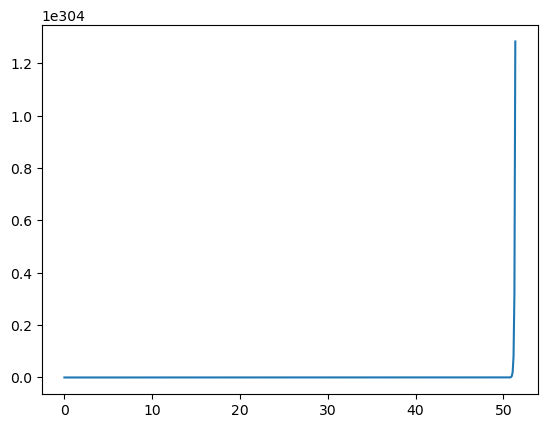

In [61]:
plt.plot(l,otp)